In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt

In [2]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(18, 128)  # Increased number of neurons
        self.fc2 = nn.Linear(128, 128)  # Added more neurons
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 64)    # Added another hidden layer
        self.fc5 = nn.Linear(64, 18)    # Output: 9 positions + 9 velocities

        # Adding BatchNorm layers (helps normalize activations)
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(64)

        # Adding dropout layers (helps reduce overfitting)
        self.dropout = nn.Dropout(0.1)  # Dropout rate 30%

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)  # Apply dropout after the first layer
        
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)  # Apply dropout after the second layer
        
        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)  # Dropout again after the third layer

        x = torch.relu(self.fc4(x))  # Fourth hidden layer without batchnorm or dropout
        x = self.fc5(x)  # Final output layer
        return x

In [3]:
def physics_loss(predicted_positions_and_velocities, positions_and_velocities):
    # Extract current positions and velocities from the input
    x1, y1, z1, vx1, vy1, vz1 = positions_and_velocities[:, 0], positions_and_velocities[:, 1], positions_and_velocities[:, 2], positions_and_velocities[:, 3], positions_and_velocities[:, 4], positions_and_velocities[:, 5]
    x2, y2, z2, vx2, vy2, vz2 = positions_and_velocities[:, 6], positions_and_velocities[:, 7], positions_and_velocities[:, 8], positions_and_velocities[:, 9], positions_and_velocities[:, 10], positions_and_velocities[:, 11]
    x3, y3, z3, vx3, vy3, vz3 = positions_and_velocities[:, 12], positions_and_velocities[:, 13], positions_and_velocities[:, 14], positions_and_velocities[:, 15], positions_and_velocities[:, 16], positions_and_velocities[:, 17]

    # Gravitational constant and masses
    G = 6.67430e-11
    m1, m2, m3 = 10, 20, 30
    dt = 1
    
    # Distances between bodies
    r12 = torch.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
    r13 = torch.sqrt((x3 - x1)**2 + (y3 - y1)**2 + (z3 - z1)**2)
    r23 = torch.sqrt((x3 - x2)**2 + (y3 - y2)**2 + (z3 - z2)**2)

    # Compute accelerations using Newton's Law of Gravitation
    ax1 = G * (m2 * (x2 - x1) / r12**3 + m3 * (x3 - x1) / r13**3)
    ay1 = G * (m2 * (y2 - y1) / r12**3 + m3 * (y3 - y1) / r13**3)
    az1 = G * (m2 * (z2 - z1) / r12**3 + m3 * (z3 - z1) / r13**3)
    
    ax2 = G * (m1 * (x1 - x2) / r12**3 + m3 * (x3 - x2) / r23**3)
    ay2 = G * (m1 * (y1 - y2) / r12**3 + m3 * (y3 - y2) / r23**3)
    az2 = G * (m1 * (z1 - z2) / r12**3 + m3 * (z3 - z2) / r23**3)

    ax3 = G * (m1 * (x1 - x3) / r13**3 + m2 * (x2 - x3) / r23**3)
    ay3 = G * (m1 * (y1 - y3) / r13**3 + m2 * (y2 - y3) / r23**3)
    az3 = G * (m1 * (z1 - z3) / r13**3 + m2 * (z2 - z3) / r23**3)

    # Update velocities using time step dt
    vx1_new = vx1 + ax1 * dt
    vy1_new = vy1 + ay1 * dt
    vz1_new = vz1 + az1 * dt

    vx2_new = vx2 + ax2 * dt
    vy2_new = vy2 + ay2 * dt
    vz2_new = vz2 + az2 * dt

    vx3_new = vx3 + ax3 * dt
    vy3_new = vy3 + ay3 * dt
    vz3_new = vz3 + az3 * dt

    # Combine calculated velocities into a tensor
    calculated_velocities = torch.stack((vx1_new, vy1_new, vz1_new, vx2_new, vy2_new, vz2_new, vx3_new, vy3_new, vz3_new), dim=1)

    # Extract predicted velocities (assume they are the last 9 elements)
    predicted_velocities = predicted_positions_and_velocities[:, 9:]  # Last 9 are predicted velocities

    # Compute loss as mean squared error between predicted and physics-based velocities
    return torch.mean((calculated_velocities - predicted_velocities)**2)

In [4]:
from sklearn.preprocessing import MinMaxScaler

def load_data():
    input_file = '/kaggle/input/three-body-simulation/three_body_input.csv'
    output_file = '/kaggle/input/three-body-simulation/three_body_output.csv'

    # Load CSV data into pandas DataFrames
    input_data = pd.read_csv(input_file)
    output_data = pd.read_csv(output_file)

    num_bodies = 3  # Adjust based on your data
    pos_cols = num_bodies * 3  # 3 coordinates for each body
    vel_cols = num_bodies * 3  # 3 velocities for each body

    # Combine positions and velocities to normalize together
    combined_input_data = input_data.iloc[:, :pos_cols + vel_cols]
    combined_output_data = output_data.iloc[:, :pos_cols + vel_cols]

    # Apply Min-Max normalization to scale the data between 0 and 1
    scaler = MinMaxScaler()

    scaled_inputs = scaler.fit_transform(combined_input_data)
    scaled_targets = scaler.transform(combined_output_data)

    # Convert to torch tensors
    inputs = torch.tensor(scaled_inputs, dtype=torch.float32)
    targets = torch.tensor(scaled_targets, dtype=torch.float32)

    # Create dataset and DataLoader
    dataset = TensorDataset(inputs, targets)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    return train_loader, val_loader, scaler


In [5]:
# Initialize the model, loss function, and optimizer
model = PINN()
criterion = physics_loss
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [6]:
def train(model, train_loader, optimizer, criterion, epochs=10, threshold=0.1):
    model.train()  # Set the model to training mode
    train_losses = []
    val_losses = []
    train_accuracies = []

    for epoch in range(1, epochs + 1):
        total_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        for inputs, targets in train_loader:
            # Forward pass: predict next positions and velocities
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, targets)  # physics loss on positions and velocities
            total_loss += loss.item()

            # Compute accuracy (considering the threshold for error)
            predictions = (torch.abs(outputs - targets) < threshold).float()
            correct_predictions += predictions.sum().item()
            total_predictions += predictions.numel()

            # Backward pass and optimization
            optimizer.zero_grad()  # Clear gradients
            loss.backward()        # Compute gradients
            optimizer.step()       # Update parameters

        # Calculate average training loss and accuracy
        avg_train_loss = total_loss / len(train_loader)
        avg_train_accuracy = correct_predictions / total_predictions
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_accuracy)

        # Validate the model at the end of each epoch
        val_loss, val_accuracy = validate(model, val_loader, criterion, threshold)
        val_losses.append(val_loss)

        # Print the loss and accuracy for this epoch
        print(f'Epoch [{epoch}/{epochs}], Loss: {avg_train_loss}, Validation Loss: {val_loss}')

    return train_losses, val_losses, 

In [7]:
def validate(model, val_loader, criterion, threshold=0.1):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():  # Disable gradient calculation
        for inputs, targets in val_loader:
            # Forward pass: predict next positions and velocities
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, targets)  # physics loss on positions and velocities
            total_loss += loss.item()

            # Compute accuracy (considering the threshold for error)
            predictions = (torch.abs(outputs - targets) < threshold).float()
            correct_predictions += predictions.sum().item()
            total_predictions += predictions.numel()

    avg_val_loss = total_loss / len(val_loader)  # Return average validation loss
    avg_val_accuracy = correct_predictions / total_predictions  # Return average validation accuracy
    return avg_val_loss, avg_val_accuracy

In [8]:
# Load data
train_loader, val_loader, scaler = load_data()

In [9]:
# Train the model and store loss values
num_epochs = 10 # Set the number of epochs
train_losses, val_losses = train(model, train_loader, optimizer, criterion, epochs=num_epochs)

Epoch [1/10], Loss: 0.00354274197237753, Validation Loss: 0.00016008813624484572
Epoch [2/10], Loss: 1.1795369835447201e-05, Validation Loss: 2.2068607725098177e-06
Epoch [3/10], Loss: 1.9315733867246766e-06, Validation Loss: 1.1473601467780617e-06
Epoch [4/10], Loss: 1.3008639748357758e-06, Validation Loss: 7.037253329461462e-07
Epoch [5/10], Loss: 1.0877719809158038e-06, Validation Loss: 9.354779388581943e-07
Epoch [6/10], Loss: 9.459168571413523e-07, Validation Loss: 5.336510604440007e-07
Epoch [7/10], Loss: 8.127409561997496e-07, Validation Loss: 7.179549378155932e-07
Epoch [8/10], Loss: 7.532736826675821e-07, Validation Loss: 2.8441419891969726e-06
Epoch [9/10], Loss: 7.075188128378901e-07, Validation Loss: 4.0361170562948454e-07
Epoch [10/10], Loss: 7.025551047420287e-07, Validation Loss: 6.472247829906995e-07


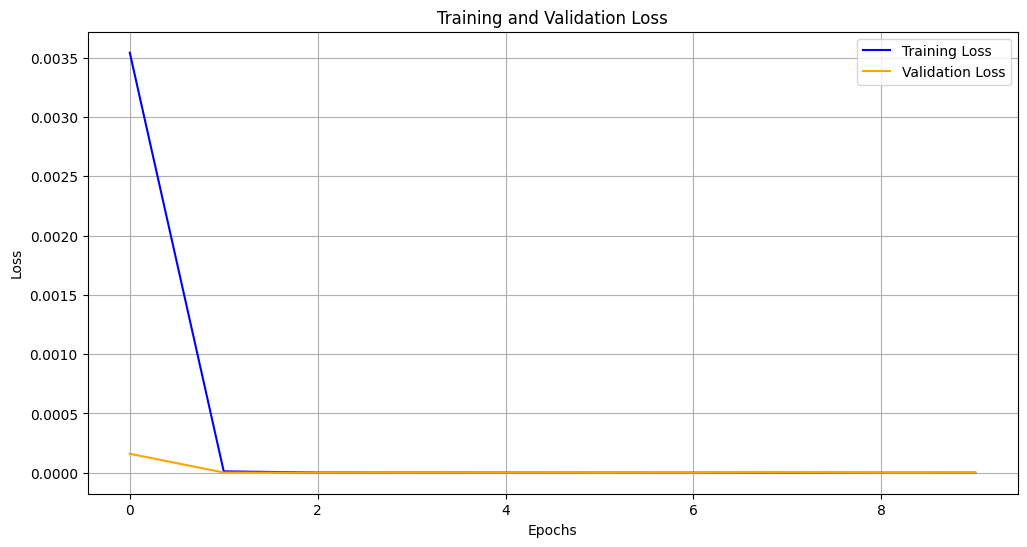

In [10]:
# Plot the training and validation loss curves
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [11]:
import torch

# Assuming your model is already defined and trained
# Replace 'model' with your model variable
# Define a dummy input tensor with the same shape as your model's input
dummy_input = torch.randn(1, 18)  # Adjust the shape according to your model's input

# Specify the filename for the ONNX model
onnx_filename = "pinn_model.onnx"

# Export the model
torch.onnx.export(
    model,                  # Model being run
    dummy_input,           # Model input (or a tuple for multiple inputs)
    onnx_filename,         # Where to save the model (can be a file or file-like object)
    export_params=True,    # Store the trained parameter weights inside the model file
    opset_version=11,      # The ONNX version to export the model to
    do_constant_folding=True, # Whether to execute constant folding for optimization
    input_names=['input'],  # The model's input names
    output_names=['output'], # The model's output names
    dynamic_axes={          # Variable-length axes
        'input': {0: 'batch_size'},  # Batch size can vary
        'output': {0: 'batch_size'}
    }
)

print(f"Model saved to {onnx_filename}")

Model saved to pinn_model.onnx
